# Designing noise-robust single-qubit gates for Rigetti Quil-T
**Increasing robustness against control noise using Boulder Opal pulses**

Boulder Opal enables you to design numerically [optimized controls](https://docs.q-ctrl.com/boulder-opal/tutorials/design-robust-single-qubit-gates-using-computational-graphs) which can improve the performance of quantum computing hardware.  Specifically, robust control solutions are able to reduce sensitivity to dephasing and/or control noise, including slowly varying noise sources that arise as hardware drifts over time.

In this application note we present an entire workflow—from gate optimization through to experimental validation on Rigetti hardware using pulse-level control through [Quil-T](https://pyquil-docs.rigetti.com/en/stable/quilt.html). We will cover:

- Preparing Rigetti's JupyterHub environment for applying Boulder Opal
- Evaluating the amplitude robustness of a default X gate
- Designing optimized amplitude-robust controls using Boulder Opal
- Validating performance using filter functions and quasi-static-noise-susceptibility scans
- Validating the optimized waveform on Rigetti quantum hardware using Quil-T

A related workflow on IBM hardware can be found in the [Designing noise-robust single-qubit gates for IBM Qiskit](https://docs.q-ctrl.com/boulder-opal/application-notes/designing-noise-robust-single-qubit-gates-for-ibm-qiskit) application note, with a detailed discussion of optimized-pulse performance published in our technical manuscript, [Error-robust quantum logic optimization using a cloud quantum computer interface](https://journals.aps.org/prapplied/abstract/10.1103/PhysRevApplied.15.064054).

*This notebook illustrates a workflow for Rigetti's JupyterLab IDE, and some cells require a booking on Rigetti's hardware. If you want to run them, please [request access to Rigetti's Quantum Cloud Services](https://qcs.rigetti.com/request-access) to set up an account.*

## Imports and initialization

To access Rigetti's Quantum Processing Units (QPUs), you will need to upload and run this notebook within Rigetti's [JupyterLab IDE](https://docs.rigetti.com/qcs/getting-started/jupyterlab-ide).
If you have not previously installed the following Q-CTRL packages, you should uncomment and run the next cell, in order to be able to import the packages and functions required for this notebook.

In [1]:
# !pip install boulder-opal
# !pip install qctrl-visualizer

Alternatively, to run the notebook locally without device-specific evaluations, set `run_locally = True` in the following cell.


In [2]:
# Whether to run notebook locally or within Rigetti's JupyterLab IDE.
run_locally = True

In the following cell you can also choose whether to run all the commands from scratch or to use previously obtained data.

In [3]:
# Whether to use saved data or to run experiments.
use_saved_data = True

In order to authenticate your Boulder Opal session remotely, you will also need to copy your authentication token to Rigetti's JupyterHub environment. 
Ensuring that your local and JupyterHub `boulder-opal` package versions match, copy your authentication token from `~/.config/qctrl` to the same location on JupyterHub.

In [4]:
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
import qctrlvisualizer as qv
import boulderopal as bo

plt.style.use(qv.get_qctrl_style())


# Rigetti imports.
if not run_locally:
    from pyquil import get_qc, Program
    from pyquil.gates import RX
    from pyquil.quilbase import DefWaveform, Frame


# Previously obtained population data encoded with jsonpickle.
if use_saved_data:
    import jsonpickle
    import jsonpickle.ext.numpy as jsonpickle_numpy

    jsonpickle_numpy.register_handlers()

    def read_variable(string):
        return jsonpickle.decode(string)

    robust_pickle = (
        '{"py/object": "numpy.ndarray", "values": "eJxF0m9ozVEYwPG8UJRZ0USGRSYMmTah7ZvC8j/bwlxZFMuKUF75'
        "sxFvvKAUjaKUkZiSiJS1FWVDocnu7W53h7u5d7/f8e+F8kKe5+z43T4vTqffec7veZ7zFKVmiHomZQvEWaYMTRYtft/KtT"
        "2qjf4i1c7FA6qT+GzVxc6bMdHNrORM8d7H9XD8zDGR8PFJWhpUivk984Thc6HDm1KVpryrTKR5UqW+8qpcZfiZp7KcO6qy"
        "uN/FAl4vUQF5v8aJgEuNKmS6mSZCru9Wls0PNglL06mTwvJ8pbJUPV0jLPk/xgvLoncLRe58w5V9wjKnt1hY6KgUlqUuMc"
        "vvMepbdL7+xi6Ri3u7WFk+zlWWW3XK8nKZyq2VnRUi9PXn8v8fd9A1PKStWoW+nyHhBIeNDzeIgNXPVomABR9KRMCXqSog"
        "mOhQe69GDOM+lwxH/Wy8vF9kOHL+sMiw7c5WYX3fDS6tMkOpK2iAWOsOYXBpVxhOn1C5/chcGGpcwgY3DgWG6vtbxADrH6"
        "0Thj+jlYnuu7pXGR6vVYMUu4vSvm+DNDc3iSHqbm8XKS4cUv18z1cp/o5SfYx1D/OJFS+Wi7ifo16fR9y/S5+vPx6tI3OY"
        'pNA1LhHt79aqBP8AjXefpQ==", "shape": [101], "dtype": "float64", "byteorder": "<"}'
    )
    square_pickle = (
        '{"py/object": "numpy.ndarray", "values": "eJw90M8rw3EYwHE7KQfKZA62+XEWcbKD9/gDxE1hI78S5eDoyB8g'
        "pJjyI9kRFzc/RnZBrZWWw2w21nezfctBOeF55pNep+fp+dXTlPaKIHVFp1hkdUHtMXg8IE447VcRNmdVFMdPhYjxWaUe2Z"
        "pWT3TE2kWK7SmVIXAwKt64KrPwRbtFnpHDYfHOrU+V+HYoG++LR9gQ6RE2z83K5qFTldiZUEXibarAV6WyzF05QpMqi7+8"
        "MMV5n0oSHlIJWpMtIm7239FVHnyNK18vzmiwXCKMs1Qr1kw8Y/6y/J//qz8iuB8QF6zPqxvc2UZxb/4XM/0JPBm3SDK+Oy"
        'bSrCypV2o+qkWO3ku/sMx9BTbmVJFfM5LN8A==", "shape": [51], "dtype": "float64", "byteorder": "<"}'
    )
    default_pickle = (
        '{"py/object": "numpy.ndarray", "values": "eJxF0c8rRFEUB/CNHzErdhY2bBDKjAUp31nIbEVmWCgz8iMWRon4'
        "A5QszIKSQlkIke2TBUpZ+FESVmrmefNm3pv37t2gZOOc2230WZzVufd8zzEiBknD0DX42EYy2B9hJurf64iJmy5mofS3hF"
        "jYnGZZ2DUKFlcXiI29UZbDUytzsLyyRBwkduPEwdhOgri4a2cFfAaYh5MB5mFjhnl4CDIf3xVMIHo8SHzEjqJEIHLeSwTK"
        "f8qIwFkfk7gMM6nnkEimZolE+ApEYmprkkisJ5ks9r01MInbDiaB624iivVgmAmdV2Bie5z4eGliPlqem8l/joseVkBIBX"
        'ER+KokLqpFFXHQqT7KI64GzWPoMEZyOo+N10Zm47SfZfX7Fu5DzCreZW2efeh9Z2DWKphTAdP4A812+Ng=", '
        '"shape": [60], "dtype": "float64", "byteorder": "<"}'
    )

## Evaluation of default X gate amplitude robustness

We will evaluate X gates on a Rigetti quantum device.
The total Hamiltonian of the driven quantum system is:

$$ H(t) = (1+\beta_\gamma (t)) H_c(t),$$

where $\beta_\gamma(t)$ is a fractional time-dependent amplitude fluctuation process, and $H_c(t)$ is the control term given by

\begin{align*}
H_c(t) = & \frac{1}{2}\left(\gamma^*(t) \sigma_- + \gamma(t) \sigma_+ \right) \\
= & \frac{1}{2}\left(I(t) \sigma_x + Q(t) \sigma_y \right).
\end{align*}

Here, $\gamma(t) = I(t) + i Q(t)$ is the time-dependent complex-valued control pulse waveform and $\sigma_k$, $k=x,y,z$, are the Pauli matrices.

We begin by evaluating the default gate on the device; we will later use the duration of the default waveform to define our amplitude-robust waveform.
Here we evaluate the robustness of the default waveform $\gamma(t)$ using a quasi-static scan over $\beta_\gamma$.

First, set up the target QPU and compiler, and obtain the device calibrations.

In [5]:
if not run_locally:
    qc = get_qc("Aspen-M-2", compiler_timeout=100)
    cals = qc.compiler.get_calibration_program()

Next we define a function that will set up a hardware experiment (program) that illustrates pulse-level control using Quil-T.
We define a custom waveform `my_waveform`, include it as part of a custom gate definition `CustomX`, and apply our custom gate as part of a program using [parametric compilation](https://pyquil-docs.rigetti.com/en/stable/quilt_parametric.html).
Parametric compilation allows faster evaluation of some forms of programs by allowing free parameters to be varied post-compilation.
In our program we set a free `scale` parameter to vary the amplitude of the given waveform, apply our `CustomX` gate to the initial state $|0\rangle$, then implement measurement on the given qubit.
The custom waveform definition must be added to the program, along with the number of measurement shots.

In [6]:
shot_count = 1028


def custom_pulse_parametric_program(waveform, qubit):
    new_waveform = DefWaveform(name="my_waveform", parameters=[], entries=waveform)
    program = Program(
        f"""
        DEFCAL CustomX {qubit}:
            FENCE {qubit}
            NONBLOCKING PULSE {qubit} "rf" my_waveform
            FENCE {qubit}""",
        "DECLARE scale REAL[1]",
        f'SET-SCALE {qubit} "rf" scale',
        f"CustomX {qubit}",
        "DECLARE ro BIT[1]",
        f"MEASURE {qubit} ro[0]",
    )
    program += new_waveform
    program.num_shots = shot_count
    return program

Next, given access to the QPU through Rigetti's IDE, you can choose a target qubit and obtain the default gate waveform and its properties. You can then obtain the parametric program using the default waveform, and compile the program.

In [7]:
qubit = 22

if not run_locally:
    x_calibration = deepcopy(cals.get_calibration(RX(np.pi, qubit)))
    sample_rate = cals.frames[Frame(qubits=[qubit], name="rf")].sample_rate
    default_function = x_calibration.instrs[1].waveform
    default_waveform = default_function.samples(rate=sample_rate)
    duration = len(default_waveform) * (1 / sample_rate)  # s
    print(default_function)
    default_program = custom_pulse_parametric_program(default_waveform, qubit)
    executable = qc.compiler.native_quil_to_executable(default_program)

Now you can run the program on the hardware during your booking window. Below, we take the sum over the shot results, which gives the probability of measuring the target $|1\rangle$ state.

In [8]:
default_scales = np.linspace(0.5, 1.5, 60)

if not use_saved_data:
    default_population = []
    for scale in default_scales:
        executable.write_memory(region_name="scale", value=scale)
        results = qc.run(executable)
        default_population.append(np.sum(results.readout_data["ro"]) / shot_count)
else:
    default_population = read_variable(default_pickle)

You can then plot the state fidelity over the amplitude scan as a measure of amplitude robustness. The control amplitude error $\beta_\gamma$ is relative to the ideal amplitude scale, which is unity.

Best infidelity: 7.782e-03


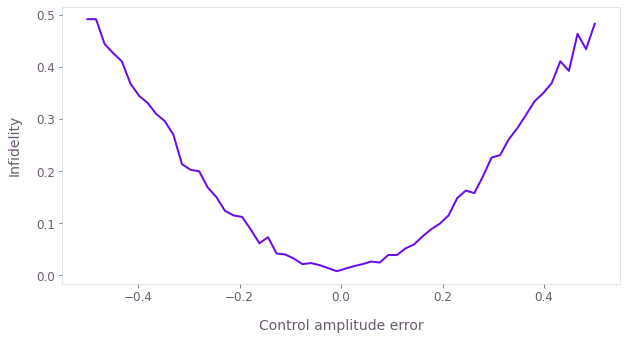

In [9]:
print(f"Best infidelity: {1 - np.max(default_population):.3e}")

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(default_scales - 1, 1 - np.array(default_population))
ax.set_xlabel("Control amplitude error")
ax.set_ylabel("Infidelity")
plt.show()

## Creation and verification of amplitude-robust Boulder Opal pulses

We use Boulder Opal to perform optimizations to achieve an X-gate operation on the qubit. 
We optimize a square pulse using the default pulse duration, and a smooth amplitude-robust pulse with slightly longer duration to facilitate more robust solutions.
We then characterize the pulse robustness using filter functions and quasi-static scans.

### Creating amplitude-robust pulses

We begin by optimizing the amplitude of a square pulse for a simulation performance benchmark, using the duration of the current (or saved) default pulse. Note that pulses with different durations will require different amplitude limits.

Your task (action_id="1827927") has started.
Your task (action_id="1827927") has completed.
Optimized infidelity: 4.441e-16


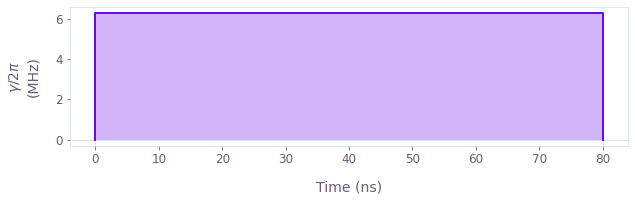

In [10]:
graph = bo.Graph()

# Create Hamiltonian.
if run_locally:
    duration = 80e-9  # s
    sample_rate = 1e9  # Hz

drive = graph.real_optimizable_pwc_signal(
    1, duration, 2 * np.pi * 8e6, 2 * np.pi * 1e6, name="drive"
)
control_hamiltonian = graph.hermitian_part(drive * graph.pauli_matrix("P"))

# Create infidelity.
infidelity = graph.infidelity_pwc(
    hamiltonian=control_hamiltonian,
    target=graph.target(graph.pauli_matrix("X")),
    name="infidelity",
)

# Calculate optimization.
square_result = bo.run_optimization(
    graph=graph, cost_node_name="infidelity", output_node_names=["drive"]
)
print(f"Optimized infidelity: {square_result['cost']:.3e}")
qv.plot_controls({r"$\gamma$": square_result["output"]["drive"]})

Next we optimize a smooth, robust pulse. 
We allow a slightly longer duration than the default pulse, which often helps to provide the necessary control freedom to increase robustness.
The returned pulse `sample_count` is defined using the hardware `sample_rate` obtained above for the default pulse.
The smoothing using `graph.filter_and_resample_pwc` is performed using a sinc filter to eliminate frequencies above the cutoff frequency, and we also apply a `graph.signals.gaussian_pulse_pwc` envelope for higher-fidelity signal generation on the hardware.

Your task (action_id="1827941") is queued.
Your task (action_id="1827941") has started.
Your task (action_id="1827941") has completed.

Optimized robust infidelity: 1.806e-11
Optimized noise-free infidelity: 4.787e-12


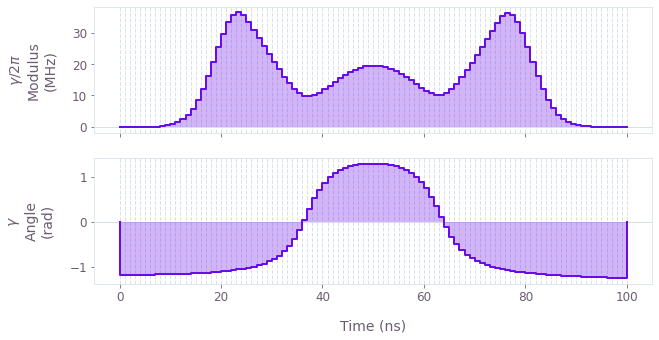

In [11]:
robust_duration = duration + 20e-9
optimization_count = 16
sample_count = round(robust_duration * sample_rate)
max_rabi_rate = 2 * np.pi * 60e6  # rad/s
cutoff_frequency = 2 * np.pi * 15e6  # rad/s

graph = bo.Graph()

# Create Hamiltonian.
drive_pwc = graph.complex_optimizable_pwc_signal(
    optimization_count, robust_duration, max_rabi_rate
)
filtered_drive = graph.filter_and_resample_pwc(
    drive_pwc,
    kernel=graph.sinc_convolution_kernel(cutoff_frequency),
    segment_count=sample_count,
)
envelope = graph.signals.gaussian_pulse_pwc(
    robust_duration, sample_count, amplitude=1.0, flat_duration=robust_duration / 2
)
filtered_drive *= envelope
filtered_drive.name = "drive"
drive_term = filtered_drive * graph.pauli_matrix("P")
control_hamiltonian = graph.hermitian_part(drive_term)

# Create noise-free infidelity.
noise_free_infidelity = graph.infidelity_pwc(
    hamiltonian=control_hamiltonian,
    target=graph.target(graph.pauli_matrix("X")),
    name="noise_free_infidelity",
)

# Create robust infidelity.
infidelity = graph.infidelity_pwc(
    hamiltonian=control_hamiltonian,
    target=graph.target(graph.pauli_matrix("X")),
    noise_operators=[0.1 * control_hamiltonian],
    name="infidelity",
)

# Calculate optimization.
robust_result = bo.run_optimization(
    graph=graph,
    cost_node_name="infidelity",
    output_node_names=["drive", "infidelity", "noise_free_infidelity"],
)
print()
print(
    f"Optimized robust infidelity: {robust_result['output']['infidelity']['value']:.3e}"
)
print(
    "Optimized noise-free infidelity: "
    f"{robust_result['output']['noise_free_infidelity']['value']:.3e}"
)
qv.plot_controls({r"$\gamma$": robust_result["output"]["drive"]})

We write the complex wavefunction as a list for implementation on the hardware.
The number of samples returned by the `filtered_drive` output corresponds to the nanosecond wavefunction resolution of the device.

In [12]:
durations = robust_result["output"]["drive"]["durations"]
values = robust_result["output"]["drive"]["values"]
robust_waveform = list((values / np.max(np.abs(values)))[np.array(durations > 1e-10)])
print("Robust waveform duration:", robust_duration)
print("Waveform samples:", len(robust_waveform))

Robust waveform duration: 1e-07
Waveform samples: 100


### Robustness characterization with filter functions and quasi-static scans

[Filter functions](https://docs.q-ctrl.com/boulder-opal/user-guides/how-to-calculate-and-use-filter-functions-for-arbitrary-controls) provide a useful way to determine the sensitivity of pulses to different time varying noise mechanisms.
The next cell generates filter functions for the Q-CTRL robust pulse and the primitive square pulse under amplitude noise.

In [13]:
sample_count = 4096
frequencies = np.logspace(-2, np.log10(max_rabi_rate), 2000)
drive_labels = ["Q-CTRL pulse", "Square pulse"]
drives = {
    "Q-CTRL pulse": robust_result["output"]["drive"],
    "Square pulse": square_result["output"]["drive"],
}

graph = bo.Graph()
for label, drive in drives.items():
    drive = graph.pwc(**drive)
    hamiltonian = graph.hermitian_part(drive * graph.pauli_matrix("P"))
    graph.filter_function(
        control_hamiltonian=hamiltonian,
        noise_operator=hamiltonian,
        frequencies=frequencies,
        sample_count=sample_count,
        name=label,
    )
filter_functions = bo.execute_graph(
    graph=graph, output_node_names=drive_labels, execution_mode="EAGER"
)["output"]

Your task (action_id="1827957") is queued.
Your task (action_id="1827957") has started.
Your task (action_id="1827957") has completed.


We next calculate the [pulse robustness against quasi-static noise](https://docs.q-ctrl.com/boulder-opal/user-guides/how-to-evaluate-control-susceptibility-to-quasi-static-noise), comparing the robust $\pi$-pulse with the primitive square pulse.
We can assess robustness to quasi-static errors in the control amplitude by scanning over the amplitude scaling factor $\beta_\gamma$.

In [14]:
amplitude_error = 0.5
amplitude_scalings = np.linspace(1 - amplitude_error, 1 + amplitude_error, 21)

graph = bo.Graph()
for label, drive in drives.items():
    durations = drive["durations"]
    values = drive["values"]
    drive_pwc = graph.pwc(durations, values)
    duration = np.sum(drive_pwc.durations)
    noise = graph.constant_pwc(
        constant=amplitude_scalings, duration=duration, batch_dimension_count=1
    )
    drive_term = noise * drive_pwc * graph.pauli_matrix("P")
    control_hamiltonian = graph.hermitian_part(drive_term)
    infidelities = graph.infidelity_pwc(
        hamiltonian=control_hamiltonian,
        target=graph.target(graph.pauli_matrix("X")),
        name=label,
    )
robustness_scans = bo.execute_graph(graph=graph, output_node_names=drive_labels)[
    "output"
]

Your task (action_id="1827968") is queued.
Your task (action_id="1827968") has started.
Your task (action_id="1827968") has completed.


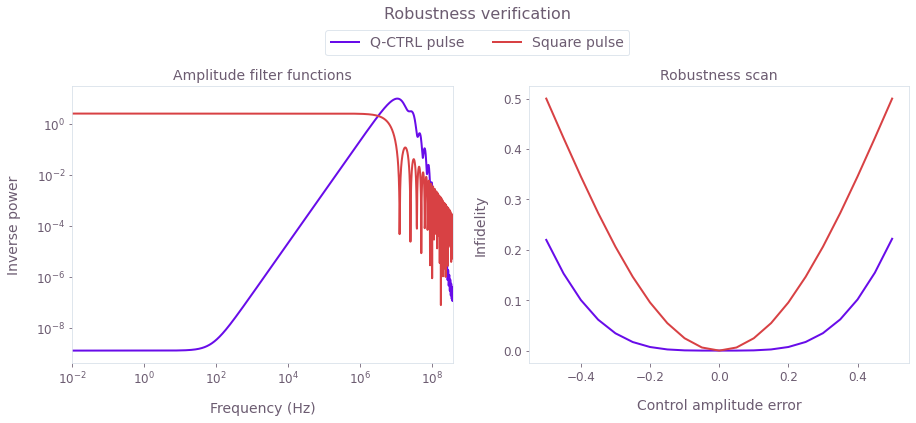

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle("Robustness verification", y=1.1)

axs[0].set_xlabel("Frequency (Hz)")
axs[0].set_ylabel("Inverse power")
axs[0].set_title("Amplitude filter functions")
axs[0].set_xlim(np.min(frequencies), np.max(frequencies))
for label, filter_function in filter_functions.items():
    axs[0].loglog(frequencies, filter_function["inverse_powers"], label=label)

axs[1].set_title("Robustness scan")
axs[1].set_ylabel("Infidelity")
axs[1].set_xlabel("Control amplitude error")
for label, infidelities in robustness_scans.items():
    axs[1].plot(amplitude_scalings - 1, infidelities["value"], label=label)


hs, ls = axs[0].get_legend_handles_labels()
fig.legend(handles=hs, labels=ls, loc="center", bbox_to_anchor=(0.5, 1.0), ncol=2)
plt.show()

Left plot: Filter functions for the control pulses under amplitude noise. The hallmark of robustness is the lower filter function values at low frequencies, which is clearly demonstrated for the Q-CTRL pulse optimized with Boulder Opal. 
Right plot: Simulated infidelity as a function of control amplitude scaling error. The Q-CTRL solution shows flat behavior for a large range of scaling values as compared to the primitive pulse, indicating robustness against amplitude error.

### Experimental robustness verification with a quasi-static scan

We now compare the implementation and performance of the pulses on Rigetti hardware.
As for the theoretical validation above, we perform a quasi-static scan over the control pulse amplitude.
We include the default X-gate for this Rigetti backend as an extra point of comparison.

For each pulse, as for the default pulse earlier:
* First compile the custom pulse program for execution on the hardware; recall that this is a parametric program with respect to amplitude scaling,
* Define the amplitude scan parameters,
* Run the program; this must be performed within a hardware booking window,
* Take the sum over the shot results, which gives the probability of measuring the target $|1\rangle$ state.

In [16]:
# Square pulse.
square_waveform = np.ones(round(duration * sample_rate))
square_scales = np.linspace(0, 0.4, 51)

if not use_saved_data:
    program = custom_pulse_parametric_program(square_waveform, qubit)
    executable = qc.compiler.native_quil_to_executable(program)
    square_population = []
    for scale in square_scales:
        executable.write_memory(region_name="scale", value=scale)
        results = qc.run(executable)
        square_population.append(np.sum(results.readout_data["ro"]) / shot_count)
else:
    robust_population = read_variable(robust_pickle)

In [17]:
# Q-CTRL robust pulse.
robust_scales = np.linspace(0, 2, 101)

if not use_saved_data:
    program = custom_pulse_parametric_program(robust_waveform, qubit)
    executable = qc.compiler.native_quil_to_executable(program)
    robust_population = []
    for scale in robust_scales:
        executable.write_memory(region_name="scale", value=scale)
        results = qc.run(executable)
        robust_population.append(np.sum(results.readout_data["ro"]) / shot_count)
else:
    square_population = read_variable(square_pickle)

You can then plot the state fidelity over the amplitude scan as a measure of amplitude robustness. Note that in the cell below we calibrate the amplitude such that the best-performing scaling factor is set to amplitude 1, and control amplitude error $\beta_\gamma$ is relative to this ideal amplitude.

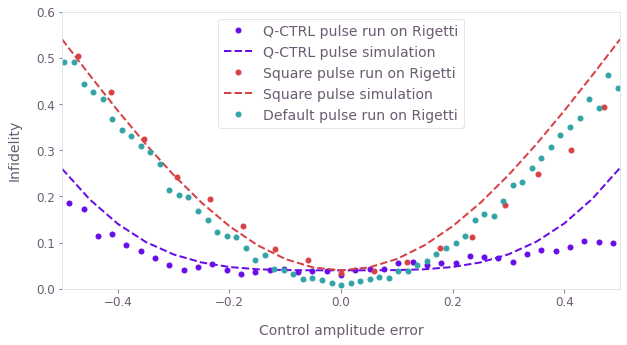

In [18]:
drive_populations = [robust_population, square_population, default_population]
drive_scales = [robust_scales, square_scales, default_scales]
labels = drive_labels + ["Default pulse"]

for index, label in enumerate(labels):
    scales = drive_scales[index]
    populations = np.array(drive_populations[index])
    scale_max_population = scales[np.argmax(populations)]
    points = plt.plot(
        scales / scale_max_population - 1,
        1 - populations,
        ".",
        label=f"{label} run on Rigetti",
        markersize=10,
    )
    if label in robustness_scans:
        plt.plot(
            amplitude_scalings - 1,
            robustness_scans[label]["value"] + 0.04,
            "--",
            color=points[0].get_color(),
            label=f"{label} simulation",
        )
plt.xlabel("Control amplitude error")
plt.ylabel("Infidelity")
plt.xlim((-0.5, 0.5))
plt.ylim((0.0, 0.6))
plt.legend()
plt.show()

The experimental quasi-static scans demonstrate the broader low-infidelity region of the Q-CTRL robust pulse.
Here the data obtained from the quantum computer is displayed as lines for the Q-CTRL, square and default pulses; the pulses have been centered to 0 error using the best-obtained fidelity value.
The theoretical quasi-static scan data is displayed as dashed lines with colors matched to the corresponding pulse type.
The default pulse is calibrated on the device, and obtains the lowest infidelity with no amplitude error.
The model-based optimized pulses have their lowest infidelity values around 4%, and the theoretical data is shifted to match this value; these pulses could be improved by tuning pulse characteristics using [closed-loop hardware optimization](https://docs.q-ctrl.com/boulder-opal/user-guides/how-to-automate-closed-loop-hardware-optimization).
Note that the default pulse is similarly susceptible to amplitude noise as the square pulse, while the Q-CTRL pulse leverages its longer duration and higher power to provide substantial robustness gains.